# Warsaw Air Pollution

<span style="color: gray; font-size:1em;">Mateusz Zajac</span>
<br><span style="color: gray; font-size:1em;">Jul-2020</span>


## Table of Contents
- [Introduction](#intro)
- [Part I - Gathering Data](#gather)
- [Part II - Assessing Data](#assess)
- [Part III - Cleaning Data](#clean)
- [Part IV - EDA](#eda)

In [1]:
import pandas as pd
import numpy as np

from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

from datetime import datetime, timedelta
import calendar


#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]


import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


import requests
import json

<a id='gather'></a>
## Part I - Gathering Data

### Meteorological data

**darksky API Key**
```
key = generation of the key is no longer available, please read https://blog.darksky.net/
```

**API Setup**
```
date = datetime.strptime('2015-01-01', '%Y-%m-%d')
timest = int(datetime.timestamp(date))
```

**Download data**
```
data_darksky = []
for i in range(365):
    darksky = json.loads(requests.get('https://api.darksky.net/forecast/{}/52.2193,21.0047,{}'
    .format(key, timest)).text)
    
    data_darksky.extend(darksky['hourly']['data'])
    
    timest += 24*60*60
    
df_darksky = pd.DataFrame(data_darksky)
```

### Pollution data from the monitoring stations
Data has been downloaded manually from the [GIOŚ archives](http://powietrze.gios.gov.pl/pjp/archives)

<a id='assess'></a>
## Part II - Assessing Data

In [2]:
# load both dataset

darksky = pd.read_hdf('data/darksky_data.h5')
gios = pd.read_hdf('data/gios_data.h5')

In [3]:
darksky.head()

,date,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,32.93,1.420067e+09,0.0,2.733,260.0,6.93,6.93
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,33.90,1.420070e+09,0.0,2.733,260.0,6.93,6.93
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,NaN,0.0,0.0,0.0,NaN,1027.7,Overcast,33.81,1.420074e+09,0.0,2.733,260.0,6.93,6.93
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.81,1.420078e+09,0.0,1.244,251.0,6.93,6.93
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.73,1.420081e+09,0.0,1.152,251.0,8.96,8.96


In [4]:
darksky.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43853 entries, 0 to 43852
Data columns (total 20 columns):
date                   43853 non-null object
apparentTemperature    43853 non-null float64
cloudCover             43853 non-null float64
dewPoint               43853 non-null float64
humidity               43853 non-null float64
icon                   42219 non-null object
ozone                  13513 non-null float64
precipAccumulation     43853 non-null float64
precipIntensity        43853 non-null float64
precipProbability      43853 non-null float64
precipType             5442 non-null object
pressure               43853 non-null float64
summary                42219 non-null object
temperature            43853 non-null float64
time                   43853 non-null float64
uvIndex                43853 non-null float64
visibility             43853 non-null float64
windBearing            43853 non-null float64
windGust               43853 non-null float64
windSpeed             

In [5]:
darksky.describe()

,apparentTemperature,cloudCover,dewPoint,humidity,ozone,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
count,43853.000000,43853.000000,43853.000000,43853.000000,13513.000000,43853.000000,43853.000000,43853.000000,43853.000000,43853.000000,4.385300e+04,43853.000000,43853.000000,43853.000000,43853.000000,43853.000000
mean,48.155300,0.575709,41.072846,0.725362,318.439369,0.000416,0.000896,0.021855,1016.543833,50.739092,1.498956e+09,0.863476,6.891712,193.698265,10.333003,7.524209
std,18.897848,0.327405,12.890181,0.180586,40.287832,0.006123,0.005747,0.093905,8.845515,16.258938,4.553279e+07,1.591354,2.244549,93.865781,7.107354,3.951228
min,-11.330000,0.000000,-9.650000,0.120000,224.200000,0.000000,0.000000,0.000000,975.200000,-4.840000,1.420067e+09,0.000000,0.062000,0.000000,0.000000,0.000000
25%,32.670000,0.250000,32.020000,0.600000,289.200000,0.000000,0.000000,0.000000,1011.400000,37.870000,1.459526e+09,0.000000,6.215000,115.000000,5.140000,4.680000
50%,47.630000,0.720000,41.080000,0.760000,315.400000,0.000000,0.000000,0.000000,1016.600000,49.890000,1.498990e+09,0.000000,6.216000,206.000000,8.480000,6.930000
75%,63.410000,0.870000,51.420000,0.870000,341.400000,0.000000,0.000000,0.000000,1022.200000,63.380000,1.538366e+09,1.000000,10.000000,270.000000,13.490000,9.830000
max,96.810000,1.000000,70.480000,1.000000,484.600000,0.307500,0.272100,0.970000,1046.700000,96.790000,1.577830e+09,8.000000,10.000000,359.000000,51.640000,38.780000


In [15]:
# check if missing values exist in the test dataset
def check_missing():
    for column in darksky.columns:
        missing = column, darksky[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('icon', 1634)
('ozone', 30340)
('precipType', 38411)
('summary', 1634)


In [17]:
darksky.icon.unique()

array([nan, 'cloudy', 'fog', 'partly-cloudy-day', 'partly-cloudy-night',
       'clear-night', 'clear-day', 'wind', 'rain', 'snow', 'sleet'],
      dtype=object)

In [18]:
darksky.summary.unique()

array([nan, 'Overcast', 'Foggy', 'Mostly Cloudy', 'Partly Cloudy',
       'Clear', 'Dangerously Windy and Mostly Cloudy',
       'Windy and Mostly Cloudy', 'Windy and Partly Cloudy',
       'Windy and Overcast', 'Light Rain',
       'Dangerously Windy and Partly Cloudy', 'Drizzle',
       'Possible Drizzle', 'Possible Light Rain', 'Possible Flurries',
       'Possible Light Sleet', 'Light Snow', 'Light Sleet', 'Flurries',
       'Rain', 'Light Rain and Windy', 'Possible Light Snow',
       'Possible Drizzle and Windy', 'Possible Light Rain and Windy',
       'Windy', 'Possible Light Rain and Dangerously Windy',
       'Light Rain and Dangerously Windy', 'Rain and Windy'], dtype=object)

In [19]:
darksky.precipType.unique()

array([nan, 'rain', 'snow', 'sleet'], dtype=object)

In [6]:
gios.head()

,date,pm25_nie,pm25_kon,pm25_wok
0,2015-01-01 00:00:00,51.5034,78.085,51.320000
1,2015-01-01 01:00:00,71.8204,78.085,68.982316
2,2015-01-01 02:00:00,42.6996,64.460,48.707108
3,2015-01-01 03:00:00,38.2824,36.210,37.986883
4,2015-01-01 04:00:00,35.4194,29.585,33.675489


In [7]:
gios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43853 entries, 0 to 43852
Data columns (total 4 columns):
date        43853 non-null object
pm25_nie    43853 non-null float64
pm25_kon    43853 non-null float64
pm25_wok    43853 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


In [8]:
gios.describe()

,pm25_nie,pm25_kon,pm25_wok
count,43853.000000,43853.000000,43853.000000
mean,25.296143,31.188994,19.677586
std,16.907685,26.346212,14.572871
min,0.877018,0.010000,1.281766
25%,13.535946,11.300000,9.438459
50%,20.661466,20.960000,15.640000
75%,31.902000,46.402488,25.220000
max,187.930147,256.028970,155.365434


In [16]:
# check if missing values exist in the test dataset
def check_missing():
    for column in gios.columns:
        missing = column, gios[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [10]:
darksky.date.min(), darksky.date.max()

('2015-01-01 00:00:00', '2019-12-31 23:00:00')

In [11]:
gios.date.min(), gios.date.max()

('2015-01-01 00:00:00', '2019-12-31 23:00:00')

In [12]:
# set dates to timestamps
darksky['date'] = pd.to_datetime(darksky.date)
gios['date'] = pd.to_datetime(gios.date)

In [13]:
# merge the data

df = pd.merge(darksky, gios, on=['date'], how='left')

In [14]:
df.to_hdf('data/warsaw_air_pollution_2015-2019.h5', key='df', format='t')

<a id='clean'></a>
## Part III - Cleaning Data
**and basic feature engineering for EDA**

In [36]:
# extract parts of the date
df['hour'] = df.date.dt.hour
df['day'] = df.date.dt.day
df['dayofyear'] = df.date.dt.dayofyear
df['weekday'] = df.date.dt.weekday
df['month'] = df.date.dt.month
df['quarter'] = df.date.dt.quarter
df['year'] = df.date.dt.year

In [37]:
# divide a week to weekdays and weekends
df['IsWeekend'] = df['weekday'].apply(lambda x: 0 if x <5 else 1)

In [38]:
# mapping months to seasons
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Autumn', 'Autumn', 'Autumn', 1]
month_to_season = dict(zip(range(1,13), seasons))

df['season'] = df.month.map(month_to_season)

<a id='eda'></a>
## Part IV - EDA

Wall time: 581 ms


(19.0, 0.0)

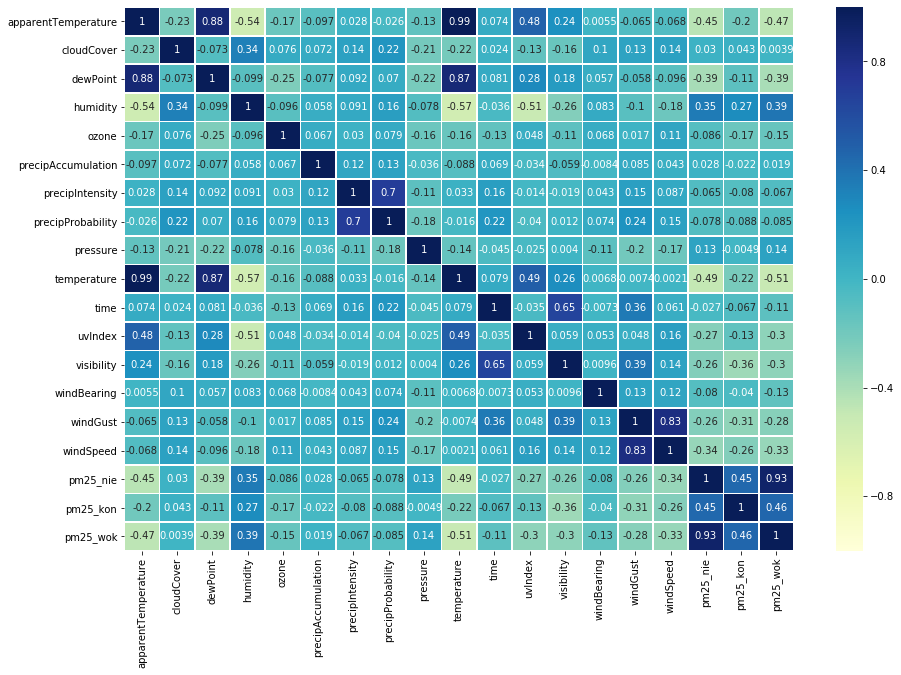

In [20]:
# plot correlation matrix
plt.rcParams['figure.figsize']=(15,10)
%time ax = sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

# correcting matplotlib issue with cutting edges
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

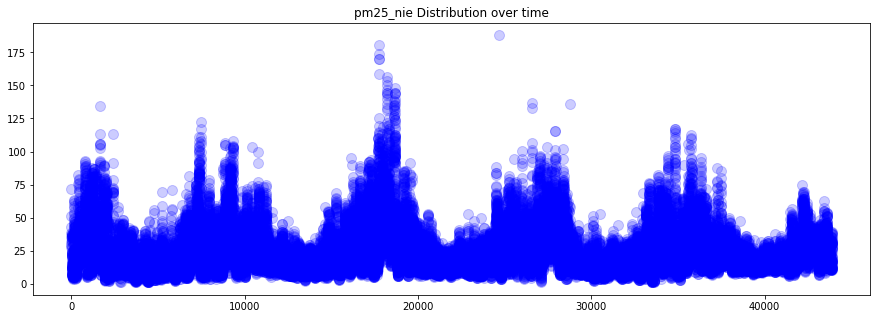

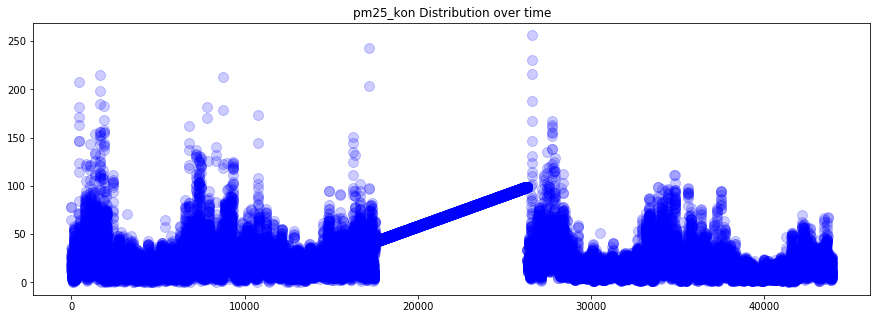

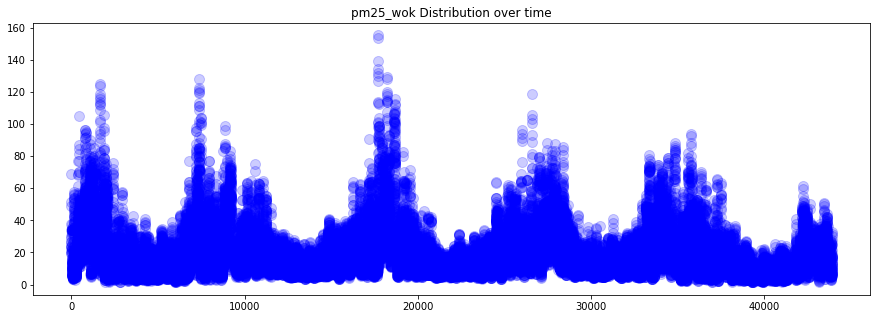

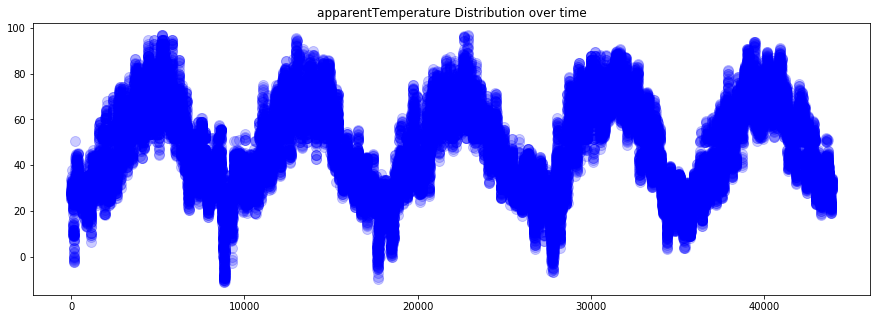

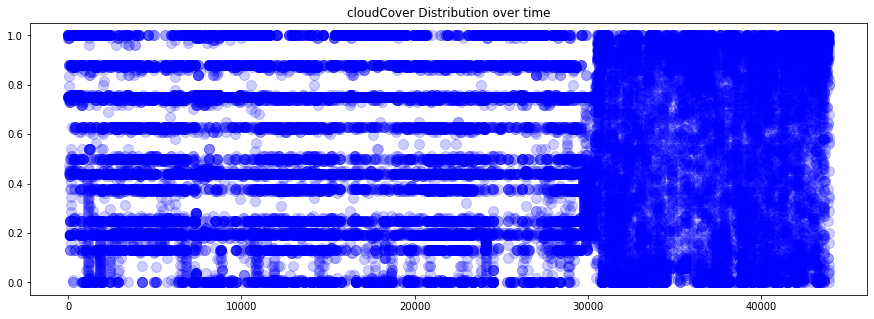

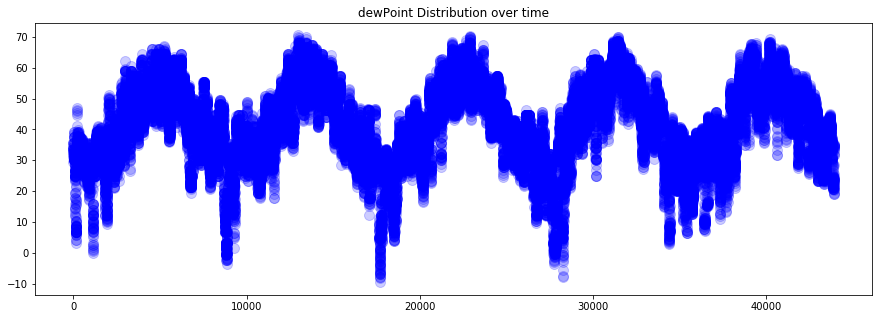

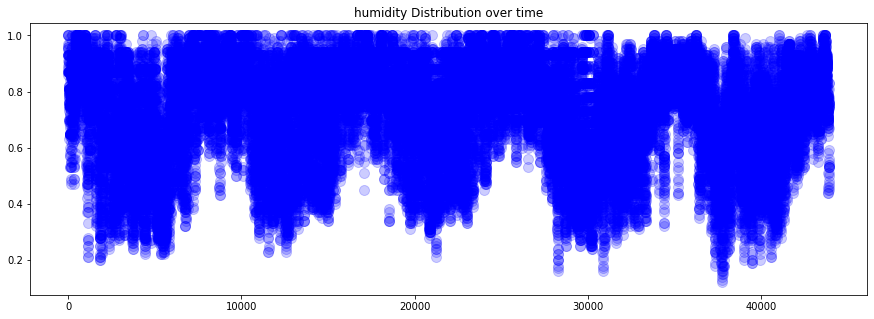

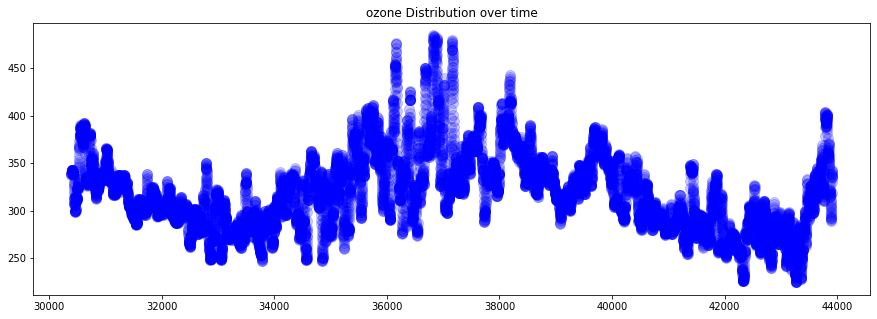

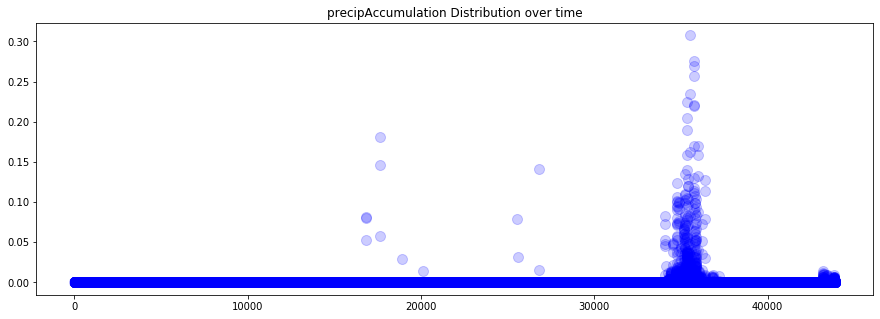

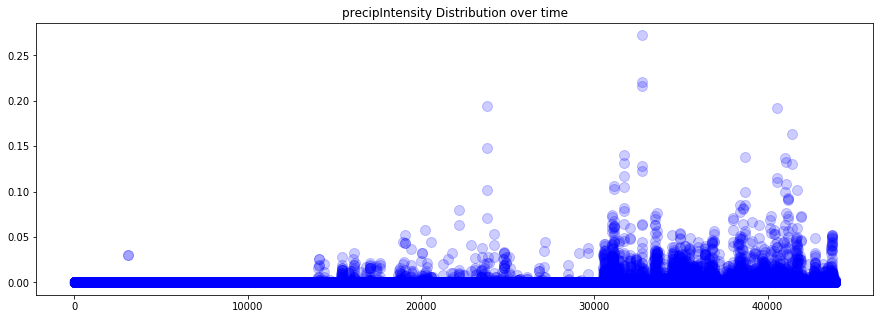

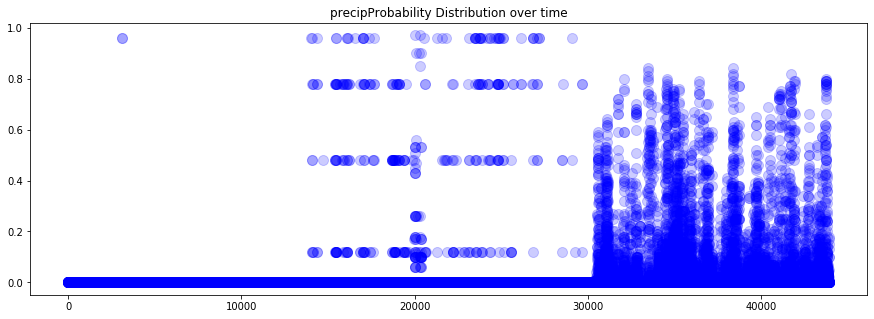

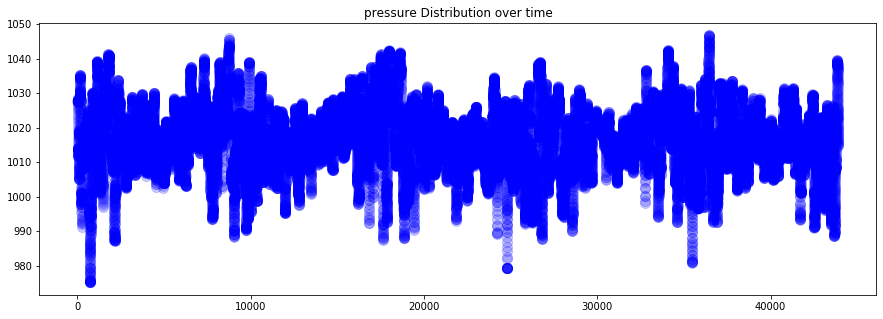

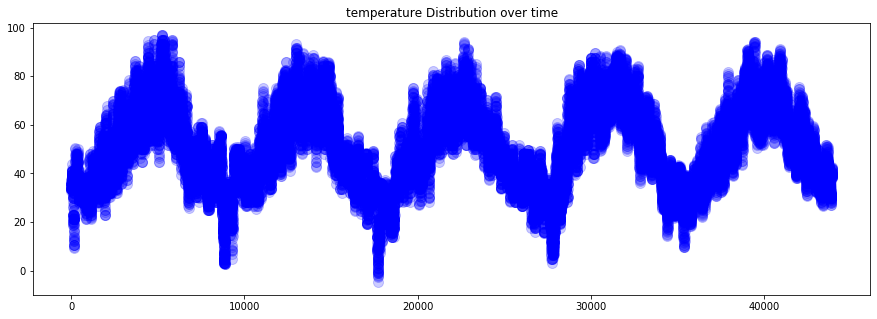

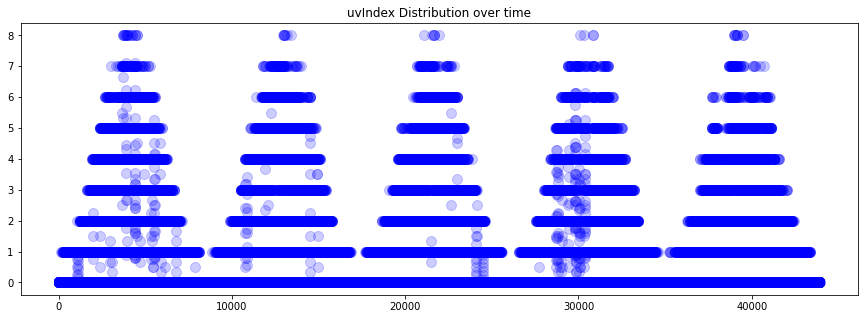

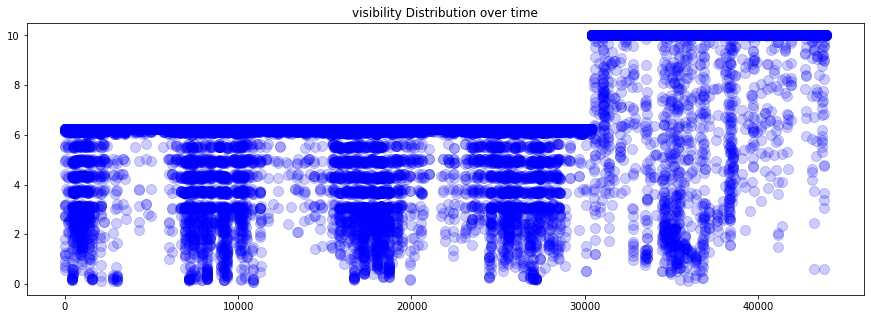

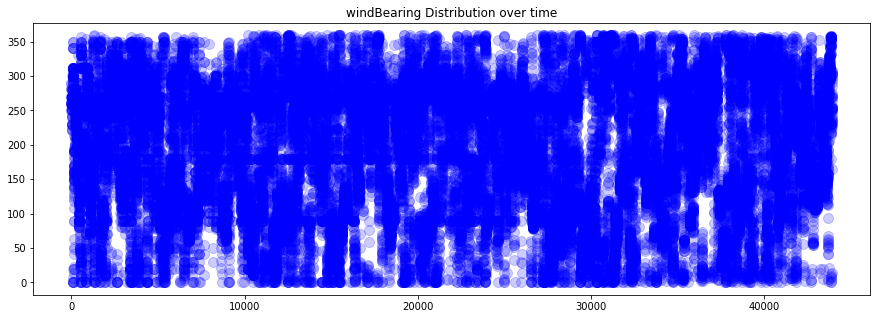

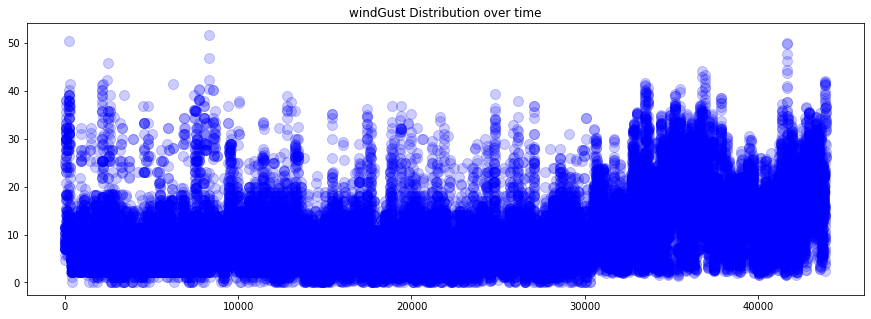

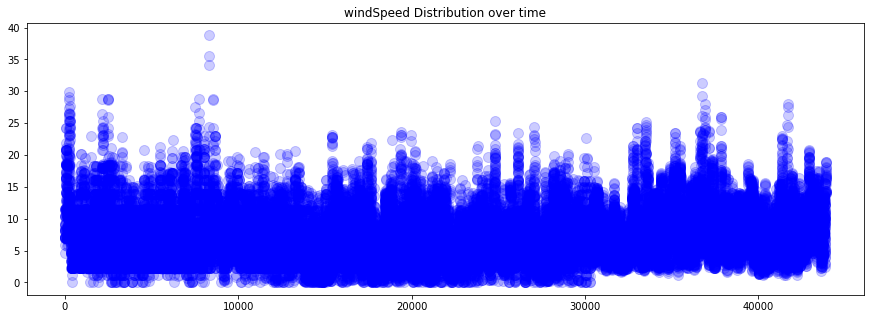

In [27]:
feats = ['pm25_nie', 'pm25_kon', 'pm25_wok', 'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone',
         'precipAccumulation', 'precipIntensity', 'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windGust', 'windSpeed']


for x in feats:
    plt.figure(figsize=(15, 5))
    plt.title('{} Distribution over time'.format(x))
    plt.plot(df.index, df[x], 'bo', alpha=0.2, ms=10, lw='3');

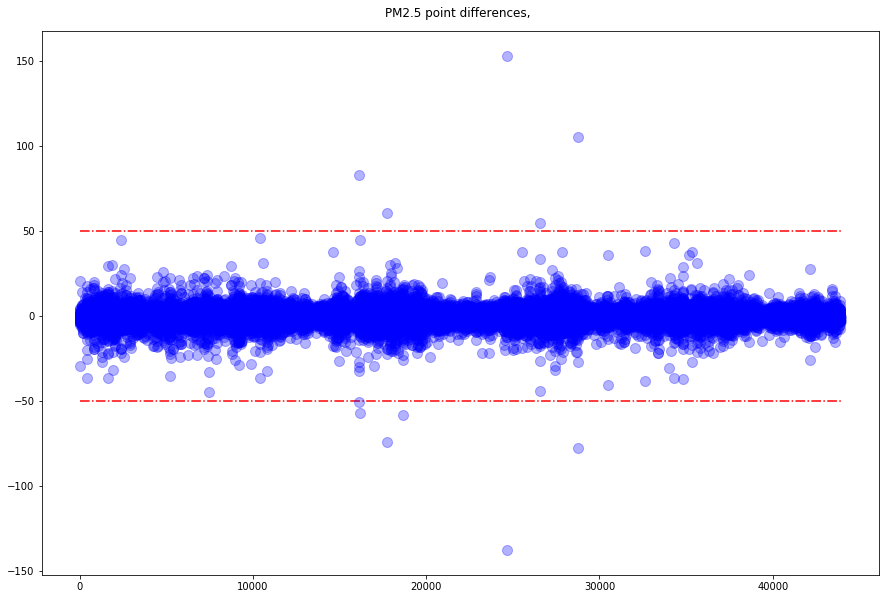

In [35]:
plt.plot(df.index, df['pm25_nie'].diff(), 'bo', alpha=0.3, ms=10, lw='3')

plt.title("PM2.5 point differences, ", y=1.015)
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=50, color='r', linestyle='-.')
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=-50, color='r', linestyle='-.');

In [24]:
scatter_data = df[ ['date', 'pm25_nie'] ]
#scatter_data = scatter_data[ False == scatter_data['pm25_nie'].isnull() ]

bins = pd.IntervalIndex.from_tuples([ (0, 12), (12, 35.5), (35.5, 55.5), 
                                      (55.5, 150.5), (150.5, 250.5), (250.5, np.max(scatter_data['pm25_nie'])) ])
scatter_data['PM2.5_cat'] = pd.cut(scatter_data['pm25_nie'], bins)

labels=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy","Hazardous"]
station_cat_dict = dict(zip(bins, labels))
scatter_data['PM2.5_cat'] = scatter_data['pm25_nie'].map(station_cat_dict)

#plot
plt.figure(figsize=(18, 6))
plt.title("PM2.5 level and its healt impact", y=1.015)

# Unique category labels: 'D', 'F', 'G', ...
color_labels = scatter_data['PM2.5_cat'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("RdYlGn_r", 6)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
plt.scatter(x='date', y='pm25_nie', data=scatter_data, c=scatter_data['PM2.5_cat'].map(color_map));

ValueError: left side of interval must be <= right side

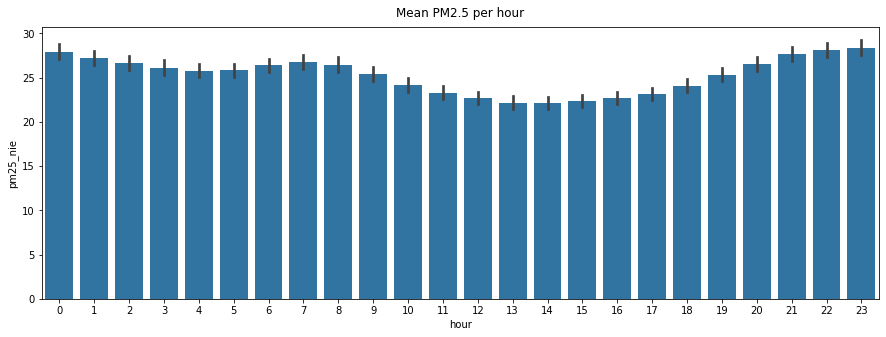

In [39]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per hour across all years", y=1.015)
sns.barplot(x="hour", y="pm25_nie", data=df, color=base_color);

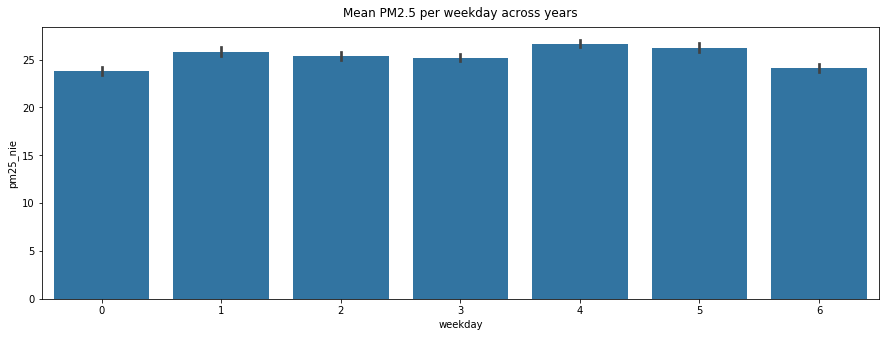

In [42]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per weekday across years", y=1.015)
sns.barplot(x="weekday", y="pm25_nie", data=df, color=base_color);

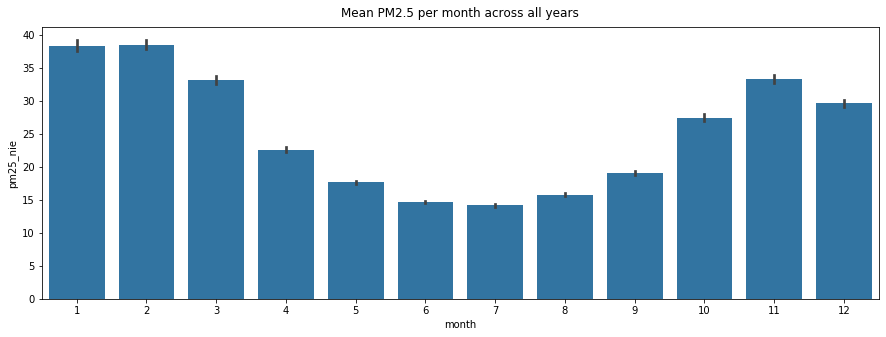

In [43]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per month across all years", y=1.015)
sns.barplot(x="month", y="pm25_nie", data=df, color=base_color);

In [ ]:
df_train = df.groupby(["year", "month"])["pm25_nie"].mean().reset_index()
df_train['date'] = df_train[["year", "month"]].apply(lambda x: '{0}-{1}'.format(x['year'], x['month']), axis=1)

plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per month across for years 2015-2019", y=1.015)
chart = sns.barplot(x="date", y="pm25_nie", data=df, color=base_color)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [ ]:
plt.figure(figsize=(18, 5))

# heatmap for PM2.5 over the weekday and hour
df_train = df.groupby(["weekday", "hour"])["pm25_nie"].mean().reset_index()
df_train = df_train.pivot("weekday", "hour", "pm25_nie")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

# korekta błędu w matplotlib, który ucina krawędzie heatmapy
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Mean PM2.5 Heatmap per hour and day of the week", y=1.015)
plt.xlabel('Hour')
plt.ylabel('Day of the Week');

In [ ]:
plt.figure(figsize=(18, 8))

# heatmap for PM2.5 over the month and hour
df_train = train_copy.groupby(["month", "hour"])["pm25_nie"].mean().reset_index()
df_train = df_train.pivot("month", "hour", "pm25_nie")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

# korekta błędu w matplotlib, który ucina krawędzie heatmapy
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Mean PM2.5 Heatmap per hour and month", y=1.015)
plt.xlabel('Hour')
plt.ylabel('Month');